In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

In [4]:
# imports
import tensorflow as tf
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
import string
import numpy as np
import pandas as pd

2022-12-15 14:01:21.708989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# experiment name
name = 'both_generated_using_correct_names_20k'

# Dataset

In [6]:
df = pd.read_csv(f"data/{name}.csv")
print(df.shape)
df.sample(10)

(20000, 2)


,Name,class
17633,ججنا فشعرت مقاله,0.0
96,موفق ناروز دولت,1.0
16044,ماىر رههج كامر,0.0
14859,راغب قصرها رااائع,0.0
17092,ععطوى عدالة ععببداالبباقى,0.0
12290,ننعم وفاء نشات,0.0
17134,فريينا معاطى لطيف،,0.0
3295,سريع عكاشة اهيم,1.0
11475,لحمدياسدا كر ناكازيش,0.0
16491,الفاضلة الاسبوع يفيض,0.0


In [7]:
# max number of words per name
df['Name'].str.split().str.len().max()

3

In [8]:
df.head(5)

,Name,class
0,حمايه تيسير لاوند,1.0
1,سعداحمد ابراهبم برى,1.0
2,مكة ولاء كريمه,1.0
3,زايد ثراء سحاق,1.0
4,الاسمر الشندى العوضى,1.0


In [9]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Name,class
0,شعيب نفاد عبيدالله,1.0
1,شهندا بسيم سدراك,1.0
2,تسنيم مكاريوس الجوهره,1.0
3,قدرى الربيع شكيب,1.0
4,متعلق منيتتى هاادب,0.0


## Document Preprocessing

In [10]:
# adding start and end tokens
names = ['<SOS> ' + x + ' <EOS>' for x in df['Name'].tolist()]
corpus = " ".join(names)
labels = df['class'].tolist()
corpus[:1000]

'<SOS> شعيب نفاد عبيدالله <EOS> <SOS> شهندا بسيم سدراك <EOS> <SOS> تسنيم مكاريوس الجوهره <EOS> <SOS> قدرى الربيع شكيب <EOS> <SOS> متعلق منيتتى هاادب <EOS> <SOS> مسلسلات الوراء رآه <EOS> <SOS> سحاب الزهراء روتاج <EOS> <SOS> شاور سدراك محمدابو <EOS> <SOS> دجليومن يحيى لدسعا <EOS> <SOS> ميريم قتؤح ابوغنام <EOS> <SOS> ابوسبع ناظم اسما <EOS> <SOS> طمه معاز القداح <EOS> <SOS> رضى تيا سنجاب <EOS> <SOS> جبن سناء عيدس <EOS> <SOS> اللاوندى بلبل ميخائيل <EOS> <SOS> خيرالله حسان حمتو <EOS> <SOS> الرقم الاميرة فريدة <EOS> <SOS> خامد حميدو طلخان <EOS> <SOS> ننجا سومه احمددعلى <EOS> <SOS> ياقوت عربان بسيم <EOS> <SOS> جمدا رادوسيع ابز <EOS> <SOS> ميههوبب خاطرو وئام <EOS> <SOS> مهنا عبدالنظيير وردهه <EOS> <SOS> ساجد منصورعبده جواهر <EOS> <SOS> مفتعل رفيع همام <EOS> <SOS> عوعزز اتفح كرش <EOS> <SOS> عاشور ملكى عبدالقوى <EOS> <SOS> ايرينى نباء بسطاوى <EOS> <SOS> سعا عبدالساتر زاخر <EOS> <SOS> السجينى حمايل خله <EOS> <SOS> ددنندش عبداالممنجى نففيسهه <EOS> <SOS> مفررحح جبرىى بلسمم <EOS> <SOS> اىومك اهيبوصبق

## Tokenization 

In [11]:
tokenize = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=False)
tokenize.fit_on_texts(names)
x = tokenize.texts_to_sequences(names)
max_len = 6
x = tf.keras.utils.pad_sequences(x, maxlen=max_len, padding='post')
total_words = len(tokenize.word_index)+1
print(f"Total Words: {total_words}")
print("Example of a Sequence")
print(x[:3])
print("Some Tokens")
print(list(tokenize.word_index)[:10])

Total Words: 13574
Example of a Sequence
[[   2  495 3172 1386    3    0]
 [   2   38  120 1387    3    0]
 [   2  496 1025  202    3    0]]
Some Tokens
['<UNK>', '<SOS>', '<EOS>', 'عطوان', 'اعتماد', 'ثريا', 'التزام', 'حكمه', 'القداح', 'جمال']


## Splitting data and making dataset 

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x, df['class'].values, test_size=.2, random_state=23)
print("Train and Validation sizes")
len(x_train), len(x_valid), len(y_train), len(y_valid)

Train and Validation sizes


(16000, 4000, 16000, 4000)

In [13]:
y_train.sum(), y_valid.sum()

(7997.0, 2003.0)

In [14]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)

2022-12-15 14:01:26.369208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 14:01:26.400374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 14:01:26.400707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 14:01:26.402420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [15]:
for x,y in ds_train.take(1):
    print(x[:2], y[:2])

tf.Tensor(
[[    2  2596  6874    83     3     0]
 [    2  6905 12292 12293     3     0]], shape=(2, 6), dtype=int32) tf.Tensor([0. 0.], shape=(2,), dtype=float64)


# Build and Train a Model: 

In [16]:
vocab_size = total_words
embedding_dim = 128
sequence_length = max_len

In [17]:
model = tf.keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)],
  )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1737472   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,737,601
Trainable params: 1,737,601
Non-trainable params: 0
______________________________________________

In [18]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

In [19]:
early_stopping = EarlyStopping(patience=2, restore_best_weights=True, verbose=True)
epochs = 10
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/10
125/125 [==============================] - 1s 5ms/step - loss: 0.6737 - binary_accuracy: 0.5002 - val_loss: 0.6359 - val_binary_accuracy: 0.4992
Epoch 2/10
125/125 [==============================] - 1s 4ms/step - loss: 0.5297 - binary_accuracy: 0.6359 - val_loss: 0.4644 - val_binary_accuracy: 0.8310
Epoch 3/10
125/125 [==============================] - 1s 4ms/step - loss: 0.3199 - binary_accuracy: 0.9526 - val_loss: 0.3165 - val_binary_accuracy: 0.9230
Epoch 4/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1906 - binary_accuracy: 0.9797 - val_loss: 0.2417 - val_binary_accuracy: 0.9337
Epoch 5/10
125/125 [==============================] - 1s 4ms/step - loss: 0.1275 - binary_accuracy: 0.9877 - val_loss: 0.2062 - val_binary_accuracy: 0.9365
Epoch 6/10
125/125 [==============================] - 1s 4ms/step - loss: 0.0935 - binary_accuracy: 0.9908 - val_loss: 0.1879 - val_binary_accuracy: 0.9373
Epoch 7/10
125/125 [==============================] - 1s 4ms/ste

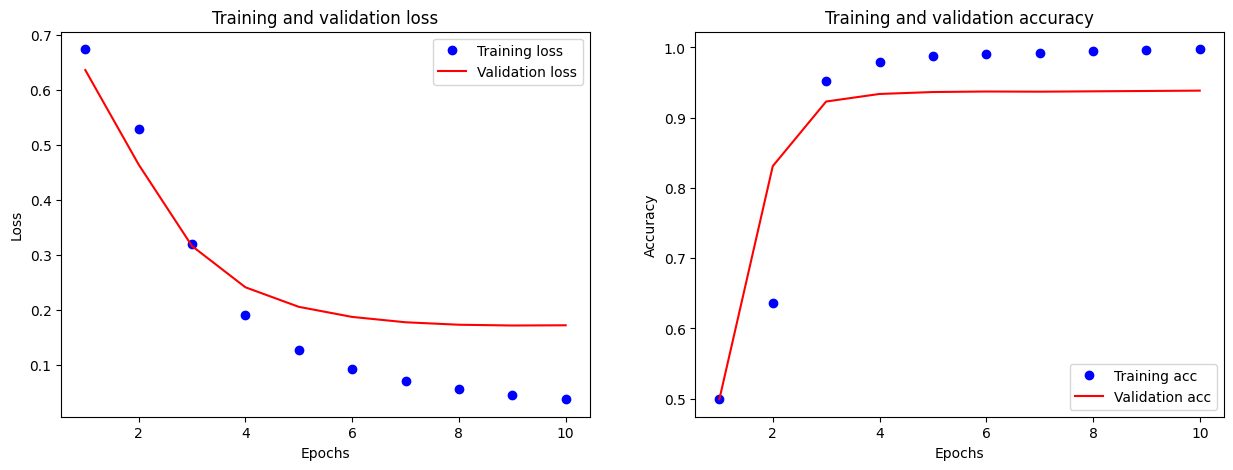

In [20]:
from utils import plot_history
plot_history(history.history)

### Test Examples 

In [21]:
#new
example = '<sos> ' + "معاذ طه عوض" + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 68ms/step


array([[0.9856778]], dtype=float32)

In [22]:
#new
example = "باسم وحيد السيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 34ms/step


array([[0.9858744]], dtype=float32)

In [23]:
#new
example = "شسي شسي شسي"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 42ms/step


array([[0.32227126]], dtype=float32)

In [24]:
#new
example = "باسمم وحةد السد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 35ms/step


array([[0.32227126]], dtype=float32)

In [25]:
#new
example = "مريم محمد محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.86231697]], dtype=float32)

In [26]:
#new
example = "محمد مريم محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 32ms/step


array([[0.86231697]], dtype=float32)

In [27]:
#new
example = "مريم محمد الرمال"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 30ms/step


array([[0.44550908]], dtype=float32)

In [28]:
#new
example = "محمد طه عوض"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 32ms/step


array([[0.8787202]], dtype=float32)

In [29]:
#new
example = "فوزىىى محسمد شنش"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 32ms/step


array([[0.32227126]], dtype=float32)

In [30]:
#new
example = "دزيادد عبت محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.4478519]], dtype=float32)

In [31]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 56ms/step


array([[0.9506272]], dtype=float32)

In [35]:
#new
example = "زياد عبدال محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 48ms/step


array([[0.94494665]], dtype=float32)

# Saving and loading the trained model 

In [36]:
model.save(f'models/{name}_model', )

INFO:tensorflow:Assets written to: models/both_generated_using_correct_names_20k_model/assets


In [38]:
new_model = tf.keras.models.load_model(f'models/{name}_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1737472   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,737,601
Trainable params: 1,737,601
Non-trainable params: 0
______________________________________________

## Saving and loading the tokenizer

In [39]:
import pickle

# saving
with open(f'models/{name}tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open(f'models/{name}tokenizer.pickle', 'rb') as handle:
    new_tokenizer = pickle.load(handle)

In [40]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 76ms/step


array([[0.9506272]], dtype=float32)